In [11]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [12]:
Train = pd.read_csv("DataSets/Train.csv")

In [13]:
Train.head()

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
0,2012-10-02 09:00:00,None,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,2012-10-02 10:00:00,None,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,2012-10-02 11:00:00,None,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,2012-10-02 12:00:00,None,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,2012-10-02 13:00:00,None,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918


In [14]:
data = {'traffic_volume':Train['traffic_volume'], 'date_time':Train['date_time']}
target = pd.DataFrame(data).set_index('date_time')
Train.drop(columns =["traffic_volume"], inplace = True)

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(target[:200])
plt.show()

<Figure size 1500x500 with 1 Axes>

In [16]:
def preProcessingScript(dataFrame):
    import pickle
    dataFrame['is_holiday'] = np.where(dataFrame['is_holiday'] == "None", "Working Day", dataFrame['is_holiday'])
    dateTimeSplits = dataFrame["date_time"].str.split(" ")
    dataFrame["Year"] = pd.DataFrame([ item[0].split("-")[0] for item in dateTimeSplits ])
    dataFrame["Month"] = pd.DataFrame([ item[0].split("-")[1] for item in dateTimeSplits ])
    dataFrame["Day"] = pd.DataFrame([ item[0].split("-")[2] for item in dateTimeSplits ])
    dataFrame["hour"] = pd.DataFrame([ item[1].split(":")[0] for item in dateTimeSplits ])
    dataFrame.drop(columns =["date_time"], inplace = True)
    mapper_fit = pickle.load(open('fitted_mapper.pkl', 'rb'))
    return mapper_fit.transform(dataFrame)

# Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, Flatten, TimeDistributed, AveragePooling1D
from tensorflow.keras.callbacks import TensorBoard
import time

def baseline_model():
    model = Sequential()
    model.add(Dense(330, input_dim=17, kernel_initializer='normal', activation='relu'))
    model.add(Dense(316, kernel_initializer='normal', activation='relu'))
    model.add(Dense(240, kernel_initializer='normal', activation='relu'))
    model.add(Dense(346, kernel_initializer='normal', activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(60, kernel_initializer='normal', activation='relu'))
    model.add(Dense(54, kernel_initializer='normal', activation='relu'))
    model.add(Dense(45, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model

In [18]:
# model = baseline_model()

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 330)               5940      
_________________________________________________________________
dense_1 (Dense)              (None, 316)               104596    
_________________________________________________________________
dense_2 (Dense)              (None, 240)               76080     
_________________________________________________________________
dense_3 (Dense)              (None, 346)               83386     
_________________________________________________________________
flatten (Flatten)            (None, 346)               0         
_________________________________________________________________
dropout (Dropout)            (None, 346)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 60)                2

In [20]:
dataForT = preProcessingScript(Train)
targetForT = target

In [21]:
dataForT.head()

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,Year,Month,Day,hour
0,11,-0.404153,1.055720,-0.670405,1.297362,-1.552441,-1.552441,0.612030,-0.008384,-0.032546,-0.269063,1,24,-1.678399,0.818182,0.033333,0.391304
1,11,0.276572,-0.249763,-0.183967,1.307378,-1.552441,-1.552441,0.692536,-0.008384,-0.032546,0.631348,1,2,-1.678399,0.818182,0.033333,0.434783
2,11,-0.499693,-0.309103,-0.183967,1.297362,-1.163334,-1.163334,0.708936,-0.008384,-0.032546,1.017238,1,19,-1.678399,0.818182,0.033333,0.478261
3,11,-1.610349,-0.309103,-0.183967,1.297362,0.003989,0.003989,0.749934,-0.008384,-0.032546,1.017238,1,19,-1.678399,0.818182,0.033333,0.521739
4,11,1.506654,-0.368443,-0.183967,1.297362,0.782204,0.782204,0.825223,-0.008384,-0.032546,0.631348,1,2,-1.678399,0.818182,0.033333,0.565217


# Execute from here

In [136]:
fieTime = int(time.time())
NAME = "Traffic-{}".format(fieTime)
modelFilename = "Train2\DLModel-{}.h5".format(fieTime)
LRfilename = "Train2\LRModel{}.pkl".format(fieTime)
outfilename = "Train2\Prediction{}.csv".format(fieTime)

In [137]:
tensorboard = TensorBoard(log_dir="logs\{}".format(NAME))
fM= model.fit(dataForT, targetForT, epochs=500, batch_size=1100, validation_split=0.01, verbose=2,callbacks=[tensorboard] )

Train on 33412 samples, validate on 338 samples
Epoch 1/500
33412/33412 - 0s - loss: 18227.8592 - val_loss: 1769204.1250
Epoch 2/500
33412/33412 - 0s - loss: 13351.9591 - val_loss: 2014898.7500
Epoch 3/500
33412/33412 - 0s - loss: 17189.6564 - val_loss: 1669309.0000
Epoch 4/500
33412/33412 - 0s - loss: 15658.1359 - val_loss: 1839390.5000
Epoch 5/500
33412/33412 - 0s - loss: 18392.4534 - val_loss: 1770442.6250
Epoch 6/500
33412/33412 - 0s - loss: 13058.4437 - val_loss: 1865653.0000
Epoch 7/500
33412/33412 - 0s - loss: 15268.4629 - val_loss: 1657660.0000
Epoch 8/500
33412/33412 - 0s - loss: 16152.7223 - val_loss: 1910917.5000
Epoch 9/500
33412/33412 - 0s - loss: 17114.1100 - val_loss: 1720129.0000
Epoch 10/500
33412/33412 - 0s - loss: 13742.2464 - val_loss: 1804415.0000
Epoch 11/500
33412/33412 - 0s - loss: 16428.5135 - val_loss: 1652985.0000
Epoch 12/500
33412/33412 - 0s - loss: 15842.3344 - val_loss: 1870725.1250
Epoch 13/500
33412/33412 - 0s - loss: 18146.2922 - val_loss: 1770882.2500

33412/33412 - 0s - loss: 15576.1027 - val_loss: 1679981.8750
Epoch 112/500
33412/33412 - 0s - loss: 16278.5959 - val_loss: 1785676.8750
Epoch 113/500
33412/33412 - 0s - loss: 14412.1097 - val_loss: 1814611.1250
Epoch 114/500
33412/33412 - 0s - loss: 16068.0760 - val_loss: 1649609.5000
Epoch 115/500
33412/33412 - 0s - loss: 16108.5780 - val_loss: 1775282.5000
Epoch 116/500
33412/33412 - 0s - loss: 13871.1268 - val_loss: 1744543.7500
Epoch 117/500
33412/33412 - 0s - loss: 15406.3281 - val_loss: 1692383.7500
Epoch 118/500
33412/33412 - 0s - loss: 16700.2211 - val_loss: 1680234.7500
Epoch 119/500
33412/33412 - 0s - loss: 18018.9595 - val_loss: 1767570.1250
Epoch 120/500
33412/33412 - 0s - loss: 11111.8856 - val_loss: 1659453.3750
Epoch 121/500
33412/33412 - 0s - loss: 16975.4635 - val_loss: 1780804.8750
Epoch 122/500
33412/33412 - 0s - loss: 12743.2990 - val_loss: 1649332.6250
Epoch 123/500
33412/33412 - 0s - loss: 15873.0109 - val_loss: 1767869.7500
Epoch 124/500
33412/33412 - 0s - loss: 

Epoch 221/500
33412/33412 - 1s - loss: 16902.8174 - val_loss: 1824696.7500
Epoch 222/500
33412/33412 - 1s - loss: 11641.3082 - val_loss: 1774948.1250
Epoch 223/500
33412/33412 - 1s - loss: 14399.9915 - val_loss: 1868728.2500
Epoch 224/500
33412/33412 - 1s - loss: 15088.8850 - val_loss: 1682363.1250
Epoch 225/500
33412/33412 - 1s - loss: 16007.7983 - val_loss: 1837335.8750
Epoch 226/500
33412/33412 - 1s - loss: 17636.2690 - val_loss: 1849390.6250
Epoch 227/500
33412/33412 - 1s - loss: 11385.9119 - val_loss: 1899400.5000
Epoch 228/500
33412/33412 - 1s - loss: 15596.3906 - val_loss: 1787955.1250
Epoch 229/500
33412/33412 - 1s - loss: 13557.0643 - val_loss: 1724321.8750
Epoch 230/500
33412/33412 - 1s - loss: 15612.9559 - val_loss: 1836531.1250
Epoch 231/500
33412/33412 - 1s - loss: 15569.5144 - val_loss: 1831204.0000
Epoch 232/500
33412/33412 - 1s - loss: 12141.0490 - val_loss: 1819791.0000
Epoch 233/500
33412/33412 - 1s - loss: 14692.2372 - val_loss: 1905208.2500
Epoch 234/500
33412/33412

Epoch 331/500
33412/33412 - 1s - loss: 12341.0544 - val_loss: 1936229.5000
Epoch 332/500
33412/33412 - 1s - loss: 16450.2923 - val_loss: 1848953.3750
Epoch 333/500
33412/33412 - 1s - loss: 11704.1731 - val_loss: 1877298.1250
Epoch 334/500
33412/33412 - 1s - loss: 14557.7740 - val_loss: 1791953.3750
Epoch 335/500
33412/33412 - 1s - loss: 15538.6530 - val_loss: 1823121.7500
Epoch 336/500
33412/33412 - 1s - loss: 12043.6585 - val_loss: 1758408.0000
Epoch 337/500
33412/33412 - 1s - loss: 15509.8241 - val_loss: 1816856.0000
Epoch 338/500
33412/33412 - 1s - loss: 16827.1549 - val_loss: 1866562.8750
Epoch 339/500
33412/33412 - 1s - loss: 12091.8903 - val_loss: 1620237.1250
Epoch 340/500
33412/33412 - 1s - loss: 15602.8313 - val_loss: 1897275.2500
Epoch 341/500
33412/33412 - 1s - loss: 15319.9064 - val_loss: 1769980.2500
Epoch 342/500
33412/33412 - 1s - loss: 11918.7402 - val_loss: 2081124.8750
Epoch 343/500
33412/33412 - 1s - loss: 15324.4959 - val_loss: 1950743.2500
Epoch 344/500
33412/33412

Epoch 441/500
33412/33412 - 1s - loss: 15052.9229 - val_loss: 1888103.2500
Epoch 442/500
33412/33412 - 1s - loss: 14622.5508 - val_loss: 1844504.0000
Epoch 443/500
33412/33412 - 1s - loss: 13403.2229 - val_loss: 1664792.2500
Epoch 444/500
33412/33412 - 1s - loss: 14853.8587 - val_loss: 1760341.0000
Epoch 445/500
33412/33412 - 1s - loss: 11377.7727 - val_loss: 1855216.1250
Epoch 446/500
33412/33412 - 1s - loss: 14439.6742 - val_loss: 1731444.5000
Epoch 447/500
33412/33412 - 1s - loss: 15541.2218 - val_loss: 1774889.6250
Epoch 448/500
33412/33412 - 1s - loss: 12734.2802 - val_loss: 1974602.6250
Epoch 449/500
33412/33412 - 1s - loss: 14240.6874 - val_loss: 1835791.0000
Epoch 450/500
33412/33412 - 1s - loss: 13690.7374 - val_loss: 2063518.8750
Epoch 451/500
33412/33412 - 1s - loss: 13338.6766 - val_loss: 1781507.3750
Epoch 452/500
33412/33412 - 1s - loss: 17282.9455 - val_loss: 1824556.8750
Epoch 453/500
33412/33412 - 1s - loss: 10700.5822 - val_loss: 1812362.0000
Epoch 454/500
33412/33412

In [138]:
model.save(modelFilename)

In [139]:
# from tensorflow import keras

In [140]:
# model = keras.models.load_model("Train2/DLModel-1564833055.h5")

In [141]:
# rcmodel = keras.models.load_model(filename)

In [142]:
orig = pd.Series(list(target["traffic_volume"]))

In [143]:
predictions = pd.Series([p[0] for p in model.predict(dataForT)])

Text(0.5,1,'Comaprison of flow Between Original and predictions')

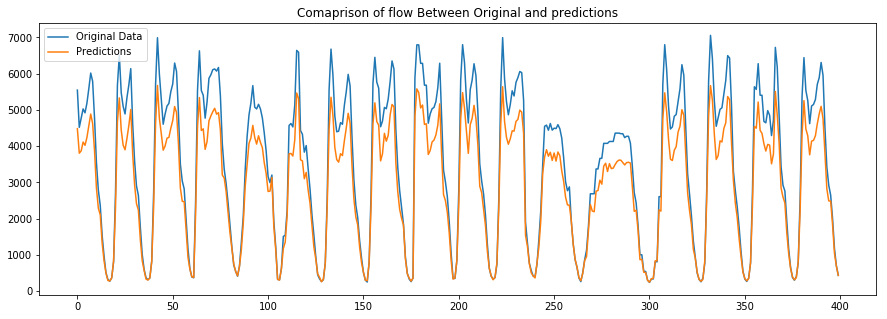

In [144]:
plt.figure(figsize=(15,5))
plt.plot(orig[:400],label="Original Data")
plt.plot(predictions[:400],label="Predictions")
plt.legend(loc='upper left')
plt.title("Comaprison of flow Between Original and predictions")

Text(0.5,1,'Comaprison of flow Between Original and predictions')

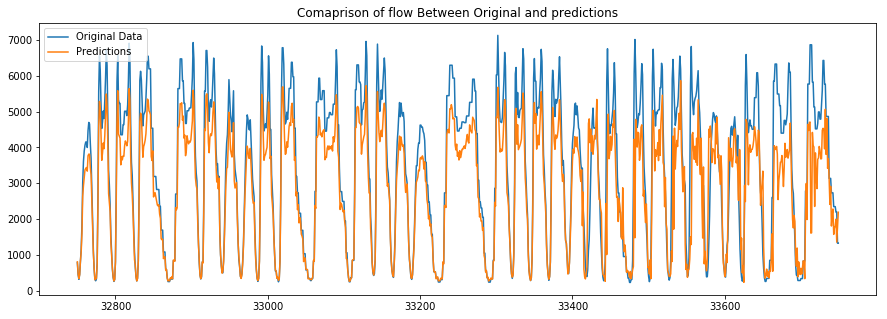

In [145]:
plt.figure(figsize=(15,5))
plt.plot(orig[-1000:],label="Original Data")
plt.plot(predictions[-1000:],label="Predictions")
plt.legend(loc='upper left')
plt.title("Comaprison of flow Between Original and predictions")

In [146]:
from sklearn.linear_model import LinearRegression

In [147]:
LRmodel = LinearRegression()

In [148]:
LRmodel.fit(np.array(predictions.tolist()).reshape(-1, 1),np.array(orig.tolist()).reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [149]:
import pickle
pickle.dump(LRmodel, open(LRfilename, 'wb'))

In [150]:
# RCLRModel = pickle.load(open(filename, 'rb'))

# Test Data

In [151]:
Test_data = pd.read_csv("DataSets/Test.csv")

In [152]:
Test_data.head()

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description
0,2017-05-18 00:00:00,None,73,63,1,27,4,4,285.15,0.0,0,90,Rain,moderate rain
1,2017-05-18 00:00:00,None,251,63,1,27,4,4,285.15,0.0,0,90,Mist,mist
2,2017-05-18 00:00:00,None,75,56,1,0,1,1,285.15,0.0,0,90,Drizzle,light intensity drizzle
3,2017-05-18 01:00:00,None,98,56,1,351,2,2,284.79,0.0,0,90,Rain,heavy intensity rain
4,2017-05-18 01:00:00,None,283,56,1,351,1,1,284.79,0.0,0,90,Mist,mist


In [153]:
def predict(model,data):
    outputDate = data["date_time"]
    preprocessedData = pd.DataFrame(preProcessingScript(data))
    return postProcessingScript(model.predict(preprocessedData),outputDate)

In [154]:
def postProcessingScript(predictions,index):
    import pandas as pd
    import numpy as np
    RCLRModel = pickle.load(open(LRfilename, 'rb'))
    filteredPredictionsIntList = [int(round(item[0])) for item in RCLRModel.predict(predictions)]
#     filteredPredictionsIntList = [int(round(item[0])) for item in predictions]
    data = {'date_time': index,'traffic_volume':filteredPredictionsIntList}
    output = pd.DataFrame(data)
    output["traffic_volume"] = np.where(output['traffic_volume']  <= 0 , output['traffic_volume'].rolling(2).median(), output['traffic_volume'])
    return output

In [155]:
predictionDataFrame = predict(model,Test_data)
predictionDataFrame.to_csv(outfilename, index=False)